Blast query elapsed time estmate.

In [8]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline

In [9]:
# Load the Census dataset
data = pd.read_csv("data/2hour.csv") #pd.read_csv("data/data_00_12.csv")
## data = data[data['dbid']!=0]
# Success - Display the first record
display(data.head(n=5))

,RID,f_ipv4,service_type,program,length_bp,dbid,dbsize_bp,started_at,run_time
0,T88615X4014,-1838318962,1,3,31,3044012,1065365425,2019-10-02T00:00:01.677,6
1,T8861CA1014,1782579084,11,1,98,3820422,85971353635,2019-10-02T00:00:01.710,2
2,T886177G014,-1596735673,8,0,68,0,123456,2019-10-02T00:00:01.693,2
3,T8861G41014,686971253,8,0,1440,6409862,251782689291,2019-10-02T00:00:04.880,8
4,T8862YYP014,1271464837,11,1,350,3820422,85971353635,2019-10-02T00:00:02.770,33


In [10]:
# Drop column that should not affect runtime of a query
subset = data.drop(['RID'], axis=1)
display(subset.head(n=5))

,f_ipv4,service_type,program,length_bp,dbid,dbsize_bp,started_at,run_time
0,-1838318962,1,3,31,3044012,1065365425,2019-10-02T00:00:01.677,6
1,1782579084,11,1,98,3820422,85971353635,2019-10-02T00:00:01.710,2
2,-1596735673,8,0,68,0,123456,2019-10-02T00:00:01.693,2
3,686971253,8,0,1440,6409862,251782689291,2019-10-02T00:00:04.880,8
4,1271464837,11,1,350,3820422,85971353635,2019-10-02T00:00:02.770,33


In [11]:
# Transform categorical features
categorical = ['service_type', 'program']
df = pd.get_dummies(pd.DataFrame(data = subset), columns=categorical)

# Apply log scale to run time
df[['run_time']] = df[['run_time']].apply(lambda x: np.log(x))
display(df.head(n=5))

,f_ipv4,length_bp,dbid,dbsize_bp,started_at,run_time,service_type_1,service_type_2,service_type_5,service_type_6,service_type_8,service_type_11,service_type_21,service_type_22,service_type_88,program_0,program_1,program_2,program_3
0,-1838318962,31,3044012,1065365425,2019-10-02T00:00:01.677,1.791759,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1782579084,98,3820422,85971353635,2019-10-02T00:00:01.710,0.693147,0,0,0,0,0,1,0,0,0,0,1,0,0
2,-1596735673,68,0,123456,2019-10-02T00:00:01.693,0.693147,0,0,0,0,1,0,0,0,0,1,0,0,0
3,686971253,1440,6409862,251782689291,2019-10-02T00:00:04.880,2.079442,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1271464837,350,3820422,85971353635,2019-10-02T00:00:02.770,3.496508,0,0,0,0,0,1,0,0,0,0,1,0,0


In [12]:
categoricals100 = ("f_ipv4", "dbid")
for c in categoricals100:
    df.loc[data[c].value_counts()[df[c]].values < 100, c] = 0
    dummies = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, dummies], axis=1)
    df.drop(c, axis=1, inplace=True)
display(df.head(n=5))    

,length_bp,dbsize_bp,started_at,run_time,service_type_1,service_type_2,service_type_5,service_type_6,service_type_8,service_type_11,...,f_ipv4_2130789544,dbid_0,dbid_62063,dbid_62073,dbid_93593,dbid_93623,dbid_779763,dbid_1335343,dbid_3820422,dbid_6154732
0,31,1065365425,2019-10-02T00:00:01.677,1.791759,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,98,85971353635,2019-10-02T00:00:01.710,0.693147,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,68,123456,2019-10-02T00:00:01.693,0.693147,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1440,251782689291,2019-10-02T00:00:04.880,2.079442,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,350,85971353635,2019-10-02T00:00:02.770,3.496508,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [13]:
df['datetime'] = pd.to_datetime(df['started_at'])
#data['datetime'] = pd.to_datetime(data['started_at'])
df.drop("started_at", axis=1, inplace=True)
dummies_hour = pd.get_dummies(df.datetime.dt.hour, prefix="hour")
df = pd.concat([df, dummies_hour], axis=1)
#data['hour'] = data.datetime.dt.hour
df.drop("datetime", axis=1, inplace=True)
print(df.head())

   length_bp     dbsize_bp  run_time  service_type_1  service_type_2  \
0         31    1065365425  1.791759               1               0   
1         98   85971353635  0.693147               0               0   
2         68        123456  0.693147               0               0   
3       1440  251782689291  2.079442               0               0   
4        350   85971353635  3.496508               0               0   

   service_type_5  service_type_6  service_type_8  service_type_11  \
0               0               0               0                0   
1               0               0               0                1   
2               0               0               1                0   
3               0               0               1                0   
4               0               0               0                1   

   service_type_21   ...    dbid_1335343  dbid_3820422  dbid_6154732  hour_0  \
0                0   ...               0             0            

In [14]:
# Select target serices
run_time = df['run_time']
df = df.drop('run_time', axis = 1)

In [15]:
# Split the features and 'run_time' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    run_time, 
                                                    test_size = 0.2, 
                                                    random_state = 12345)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 7130 samples.
Testing set has 1783 samples.


In [16]:
def r2_score(model, X, y):
    model.fit(X, y)
    return model.score(X, y)

In [17]:
def evaluate(model, X, y):
    score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    return score.mean()

In [18]:
# Establish a baseline
# Compute regressor MSE on train set using cross validation for different
# data set sizes: 1%, 10%, 100%
clf_A = AdaBoostRegressor(n_estimators=50, random_state=112233)
clf_B = RandomForestRegressor(n_estimators=50, random_state=112233)
clf_C = GradientBoostingRegressor(n_estimators=50, random_state=112233)

N = len(y_train)
samples_100 = N
samples_10 = int(0.1 * N + 0.5)
samples_1 = int(0.01 * N + 0.5)

size = {0: samples_1,
        1: samples_10,
        2: samples_100}

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = evaluate(clf, X_train[: samples], y_train[:samples])
        
for name, values in results.items():
    print("{}".format(name))
    for k, error in values.items():
        print("\tsamples={}\t\tMSE={}".format(size[k], error*-1))

AdaBoostRegressor
	samples=71		MSE=1.579469436873722
	samples=713		MSE=1.285026383558834
	samples=7130		MSE=1.4330895528578729
RandomForestRegressor
	samples=71		MSE=1.7878403151331637
	samples=713		MSE=1.1504218610301558
	samples=7130		MSE=0.8051567681068214
GradientBoostingRegressor
	samples=71		MSE=1.7951451278351638
	samples=713		MSE=0.991559689243138
	samples=7130		MSE=0.8491480776830853


In [19]:
def search(model, param_grid, X, y):
    model = RandomizedSearchCV(estimator = model, 
                               n_iter=20, 
                               param_distributions = param_grid, 
                               scoring='r2', #'neg_mean_squared_error',
                               n_jobs=4,
                               iid=False, 
                               cv=5)
    model.fit(X, y)
    return model

In [20]:
# Pick learning rate
for lr in [0.1, 0.05, 0.02, 0.01]:
    model = GradientBoostingRegressor(learning_rate=lr)
    score = r2_score(model, X_train, y_train)
    print("lr={}\tscore={}".format(lr, score))

lr=0.1	score=0.7695168510454364
lr=0.05	score=0.7431571573688882
lr=0.02	score=0.6664290614917888
lr=0.01	score=0.5409001338948862


In [21]:
learn_rate = 0.1
for i in [100, 200, 300, 500, 700, 1000]:
    model = GradientBoostingRegressor(learning_rate=learn_rate, n_estimators=i)
    score = r2_score(model, X_train, y_train)
    print("estimators={}\tscore={}".format(i, score))

estimators=100	score=0.7695168510454364
estimators=200	score=0.7871638731545237
estimators=300	score=0.7990697683451728
estimators=500	score=0.8170706948268752
estimators=700	score=0.830720177703749
estimators=1000	score=0.8458207756665823


In [22]:
# Pick max_depth and min_samples_split
param_test = {'max_depth':[x for x in range(3,21,2)], 'min_samples_split':[x for x in range(5,80,10)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_split': 5, 'max_depth': 5}


In [23]:
# Evaluate model performance
max_depth=model.best_params_['max_depth']
min_samples_split = model.best_params_['min_samples_split']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8451089216497486


In [24]:
# Pick min_samples_leaf
param_test = {'min_samples_leaf': [x for x in range(3, 15, 2)]}
model = search(GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10),
                                         param_test, 
                                         X_train, 
                                         y_train)
print(model.best_estimator_)
print(model.best_params_)

/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
{'min_samples_leaf': 3}


In [25]:
# Evaluate model performance
min_samples_leaf = model.best_params_['min_samples_leaf']
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=200, 
                                         subsample=0.8, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8378127094895954


In [26]:
# Final model.
model = GradientBoostingRegressor(learning_rate=0.1, 
                                         max_depth=max_depth,
                                         min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf,
                                         n_estimators=500, 
                                         subsample=0.7, 
                                         random_state=10)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...{}".format(score))

Train data set score...0.8697111126239393


In [27]:
# Model's performance on test data.
score = model.score(X_test, y_test)
print("Test data set score...{}".format(score))
mse = mean_squared_error(y_test, model.predict(X_test))
print("MSE: %.4f" % mse)

Test data set score...0.8072117539584259
MSE: 0.6319


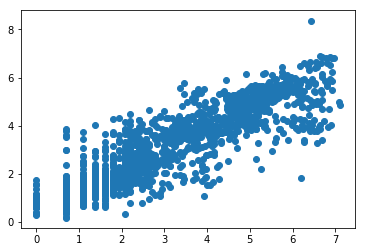

In [28]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction)

In [29]:
model = xgboost.XGBRegressor(objective="reg:squarederror", 
                             subsample=0.7,
                             learning_rate=0.1,
                             min_samples_leaf = min_samples_leaf,
                             min_samples_split=min_samples_split,
                             max_depth=max_depth, 
                             n_estimators=500)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Train data set score...R2={}, MSE={}".format(score, mean_squared_error(y_train, model.predict(X_train))))
score = model.score(X_test, y_test)
print("Test data set score...R2={}, MSE={}".format(score, mean_squared_error(y_test, model.predict(X_test))))


/home/akotliarov/anaconda3/envs/env3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train data set score...R2=0.8779871772040103, MSE=0.39250880349602624
Test data set score...R2=0.8039306245794393, MSE=0.642704567264729


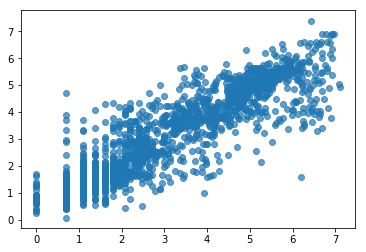

In [30]:
prediction = model.predict(X_test)
plt.scatter(y_test, prediction, alpha=0.7)